# UMB Borehole Analysis + Simulation

The UMB School of Social Work will be utilizing a geothermal system consisting of about 42 boreholes around the site. We received deviation data files for 5 of these locations.  This page presents some analytical results of these existing boreholes, and attempts to simulate how other boreholes on the site might interact, assuming similar deviation profiles to the existing. The results on this page are not definitive or statistically rigorous, and so should only be used as discussion points and prompts for further analysis.

### Library Imports and Setup
These are hidden for clarity

In [ ]:
#!pip install matplotlib
#!pip install opensimplex
#!pip install scipy
#!pip install plotly
#!pip install anywidget
#!pip install chart_studio

In [26]:
%matplotlib widget
import os
import csv
import random
from pathlib import Path
import pandas as pd
import numpy as np
#import matplotlib
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import opensimplex
from scipy.spatial import KDTree
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px

mpl.rcParams['axes3d.mouserotationstyle'] = 'azel'

sample_dist=1

#%matplotlib inline

hole_indexes = ['2-5', '2-6', '3-2', '3-3', '4-5']
filenames = [idx + " - Borehole Deviation Data_accurate.csv" for idx in hole_indexes]

#source_folder = Path(r'C:\Users\howar\OneDrive - ballingercloud\Documents\umb boreholes')
source_folder = Path(r'C:\Users\DHoward\OneDrive - ballingercloud\Documents\umb boreholes')
filepaths = [source_folder / fn for fn in filenames]

In [34]:
placemarkers_filename = "Borehole Markers.csv"
placemarkers_filepath = source_folder / placemarkers_filename

with open(placemarkers_filepath) as file:
    reader = csv.reader(file)
    data = list(reader)

origins = {}
bldg_outline = pd.DataFrame({"x":[], "y":[], "z":[]})
for row in data[1:]:
    if row[1] == "Outline":
        bldg_outline.loc[len(bldg_outline)] = {
            "x": float(row[3]),
            "y": float(row[4]),
            "z": 0.0
        }
    else:
        name = row[1]
        x = float(row[3])
        y = float(row[4])
        origins[name] = (x,y)

bldg_outline.loc[len(bldg_outline)] = bldg_outline.loc[0]

### Dataframe parameters
 - idx - Index of measurement
 - dz, dy, dx - XYZ coordinates of measurement, relative to origin of borehole
 - total_dev_ft, total_dev_pct - from original data, total deviation
 - delta_dx, delta_dy, delta_dz - difference in XYZ coordinate from previous point, ie: the vector coordinates of the move from one point to another
 - ddx, ddy, ddz - difference in amount of change from previous point - ie: did the move between points change direction or stay the same
   - asdfaf

In [3]:
def process_borehole(filepath, hole_index):
    origin_x, origin_y = origins[hole_index]
    df = pd.read_csv(filepath)
    df.dropna(inplace=True)
    df = df.set_axis(['idx', 'z', 'y', 'x', 'total_dev_ft', 'total_dev_pct'], axis=1)
    df = df[0::sample_dist] # only getting entries every <sample_dist> linear feet, could remove for every 1 foot spacing
    df.insert(1, 'hole_index', hole_index)
    df['bh_name'] = df['hole_index']
    df['z'] = -df['z']

    df['_x'] = df['x']
    df['_y'] = df['y']

    df['x'] = df['x'] + origin_x
    df['y'] = df['y'] + origin_y
    
    df['position_angle'] = np.arctan2(df['y'], df['x'])
    
    df['delta_x'] = df['x'] - df['x'].shift(1, fill_value=None)
    df['delta_y'] = df['y'] - df['y'].shift(1, fill_value=None)
    df['delta_z'] = df['z'] - df['z'].shift(1, fill_value=None)
    df['velocity_angle'] = np.arctan2(df['delta_y'], df['delta_x'])

    # to get the change in direction, need to get the difference between this delta and previous delta

    df['ddx'] = df['delta_x'] - df['delta_x'].shift(1, fill_value=None)
    df['ddy'] = df['delta_y'] - df['delta_y'].shift(1, fill_value=None)
    df['ddz'] = df['delta_z'] - df['delta_z'].shift(1, fill_value=None)
    df['acceleration_angle'] = np.arctan2(df['ddy'], df['ddx'])

    df['jx'] = df['ddx'] - df['ddx'].shift(1, fill_value=None)
    df['jy'] = df['ddy'] - df['ddy'].shift(1, fill_value=None)
    df['jz'] = df['ddz'] - df['ddz'].shift(1, fill_value=None)

    df['abs_ddx'] = df['ddx'].abs()
    df['abs_ddy'] = df['ddy'].abs()
    df['abs_ddz'] = df['ddz'].abs()

    df['d_dist'] = np.sqrt(
        (df['x'] - df['x'].shift(1))**2 +
        (df['y'] - df['y'].shift(1))**2 +
        (df['z'] - df['z'].shift(1))**2
    )
    df['d_dist_error'] = (df['d_dist'] - 10).abs()

    return df

total_stats = pd.DataFrame()
for fp, hi in zip(filepaths, hole_indexes):
    #print(fp, hi)
    df = process_borehole(fp, hi)
    #print(df.loc[0:1])
    df = df[3:]
    total_stats = pd.concat([total_stats, df])

#total_stats = total_stats.set_index(['idx', 'hole_index']) 
total_stats = total_stats.reset_index().drop('index', axis=1)
total_stats[['idx', 'hole_index', 'x', 'y', 'z', 'position_angle', 'delta_x', 'delta_y', 'delta_z', 'ddx', 'ddy', 'ddz', 'jx', 'jy', 'jz']]


,idx,hole_index,x,y,z,position_angle,delta_x,delta_y,delta_z,ddx,ddy,ddz,jx,jy,jz
0,3,2-5,124.61922,-120.44771,-2.99988,-0.768378,0.00825,0.00692,-0.99993,0.00270,0.00226,4.000000e-05,0.00157,1.310000e-03,3.000000e-05
1,4,2-5,124.62714,-120.44107,-3.99982,-0.768319,0.00792,0.00664,-0.99994,-0.00033,-0.00028,-1.000000e-05,-0.00303,-2.540000e-03,-5.000000e-05
2,5,2-5,124.63471,-120.43471,-4.99977,-0.768262,0.00757,0.00636,-0.99995,-0.00035,-0.00028,-1.000000e-05,-0.00002,-1.421085e-14,2.220446e-16
3,6,2-5,124.64337,-120.42745,-5.99970,-0.768197,0.00866,0.00726,-0.99993,0.00109,0.00090,2.000000e-05,0.00144,1.180000e-03,3.000000e-05
4,7,2-5,124.65321,-120.41919,-6.99961,-0.768123,0.00984,0.00826,-0.99991,0.00118,0.00100,2.000000e-05,0.00009,1.000000e-04,4.440892e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3023,606,4-5,84.93840,-28.08170,-598.48600,-0.319300,0.17050,0.15040,-0.97300,-0.00750,-0.00910,1.136868e-13,-0.01440,-2.400000e-02,-1.000000e-03
3024,607,4-5,85.11070,-27.93210,-599.45900,-0.317110,0.17230,0.14960,-0.97300,0.00180,-0.00080,0.000000e+00,0.00930,8.300000e-03,-1.136868e-13
3025,608,4-5,85.28380,-27.78060,-600.43200,-0.314904,0.17310,0.15150,-0.97300,0.00080,0.00190,-1.136868e-13,-0.00100,2.700000e-03,-1.136868e-13
3026,609,4-5,85.46540,-27.62440,-601.40400,-0.312624,0.18160,0.15620,-0.97200,0.00850,0.00470,1.000000e-03,0.00770,2.800000e-03,1.000000e-03


## Visualize Overall Stats

In [ ]:
selected_borehole = hole_indexes[0]
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='x', y='y', title='horizontal position')
#total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y='position_angle', title='position angle over depth', ylim=(-3.14, 3.14))
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y=['delta_x','delta_y'], title='change in position over depth', marker='o')
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y=['ddx','ddy'], title='change in acceleration over depth', marker='o')
total_stats[total_stats['hole_index'] == selected_borehole].plot.line(x='idx', y=['jx','jy'], title='jerk over depth', marker='o')


In [ ]:
total_stats[total_stats['hole_index'] == '2-5'].hist(column='angle', bins=np.arange(-4, 4, 0.2))

In [ ]:
total_stats.hist(column=['ddx', 'ddy', 'ddz'], bins=np.arange(-0.2,0.2, 0.01))

In [ ]:
total_stats[total_stats['hole_index'] == '2-5'].plot.line(x='idx', y='ddx', marker='o')

## Simulation

### Simulate Borehole function


In [44]:
def get_delta_z(delta_x, delta_y, dist):
    delta_z = np.sqrt(dist**2 - delta_x**2 - delta_y**2) * -1 # change in z direction is always down
    return delta_z
    
def simulate_borehole(sample_dist=1, origin_x = 0.0, origin_y = 0.0):
    dist = sample_dist
    df = pd.DataFrame(
        {'idx': [0],
         'x': [origin_x], 'y': [origin_y], 'z': [0.0],
         'delta_x': [0.0], 'delta_y': [0.0], 'delta_z': [0.0],
         'ddx': [0.0], 'ddy': [0.0], 'ddz': [0.0]
        }
    )
    #rand_x = np.random.choice([-1, 1])
    #rand_y = np.random.choice([-1, 1])
    rand_x = 1
    rand_y = 1
    for i in range(600):
        idx = i+1
        new_i = len(df)
        df.loc[new_i] = df.loc[new_i-1]
        df.loc[new_i, 'idx'] = idx
        ddx = np.random.choice(total_stats['ddx']) * rand_x
        ddy = np.random.choice(total_stats['ddy']) * rand_y
        df.loc[new_i, 'ddx'] = ddx 
        df.loc[new_i, 'ddy'] = ddy 
        df.loc[new_i, 'delta_x'] = df.loc[new_i, 'delta_x'] + ddx
        df.loc[new_i, 'delta_y'] = df.loc[new_i, 'delta_y'] + ddy
        delta_z = get_delta_z(df.loc[new_i, 'delta_x'], df.loc[new_i, 'delta_y'], dist)
        df.loc[new_i, 'delta_z'] = delta_z

        df.loc[new_i, 'x'] = df.loc[new_i, 'x'] + df.loc[new_i, 'delta_x']
        df.loc[new_i, 'y'] = df.loc[new_i, 'y'] + df.loc[new_i, 'delta_y']
        df.loc[new_i, 'z'] = df.loc[new_i, 'z'] + df.loc[new_i, 'delta_z']
    return df


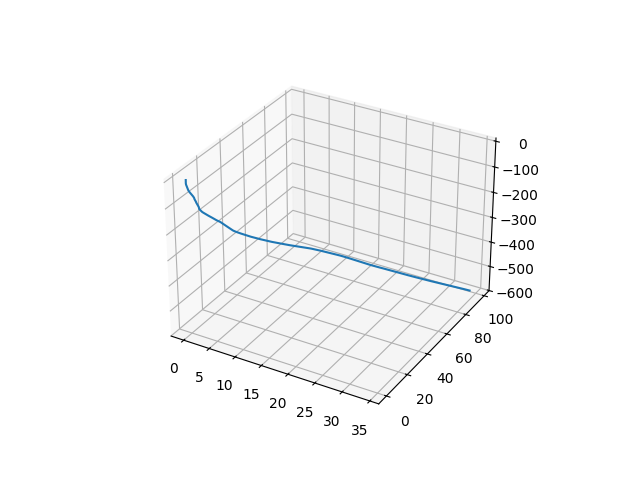

,idx,x,y,z,delta_x,delta_y,delta_z,ddx,ddy,ddz
0,0.0,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000e+00,0.0
1,1.0,0.00220,0.00250,-0.999994,0.00220,0.00250,-0.999994,0.00220,2.500000e-03,0.0
2,2.0,0.00110,0.00137,-1.999993,-0.00110,-0.00113,-0.999999,-0.00330,-3.630000e-03,0.0
3,3.0,-0.00213,-0.00346,-2.999976,-0.00323,-0.00483,-0.999983,-0.00213,-3.700000e-03,0.0
4,4.0,-0.00286,-0.01359,-3.999925,-0.00073,-0.01013,-0.999948,0.00250,-5.300000e-03,0.0
...,...,...,...,...,...,...,...,...,...,...
596,596.0,33.40929,97.38438,-584.633013,0.17874,0.22260,-0.958385,0.01510,-1.421085e-14,0.0
597,597.0,33.59003,97.60738,-585.590929,0.18074,0.22300,-0.957917,0.00200,4.000000e-04,0.0
598,598.0,33.76407,97.83078,-586.549993,0.17404,0.22340,-0.959063,-0.00670,4.000000e-04,0.0
599,599.0,33.93831,98.06658,-587.506046,0.17424,0.23580,-0.956054,0.00020,1.240000e-02,0.0


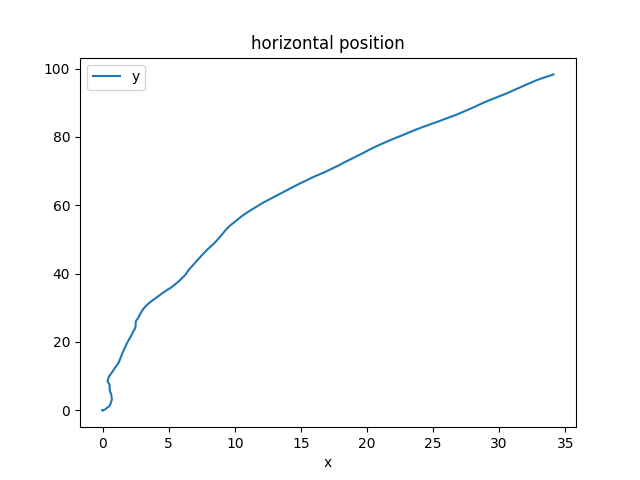

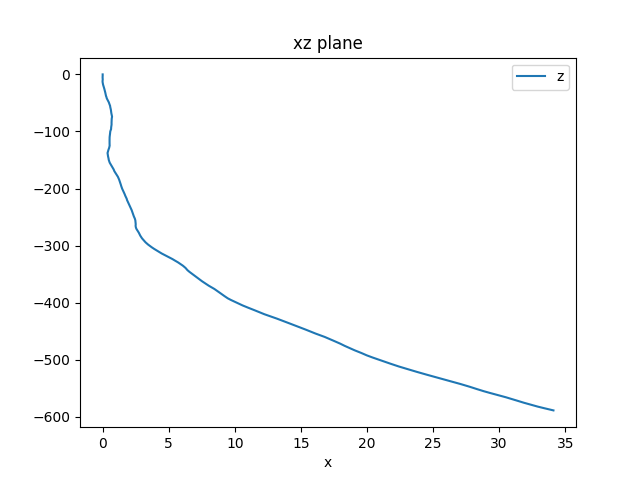

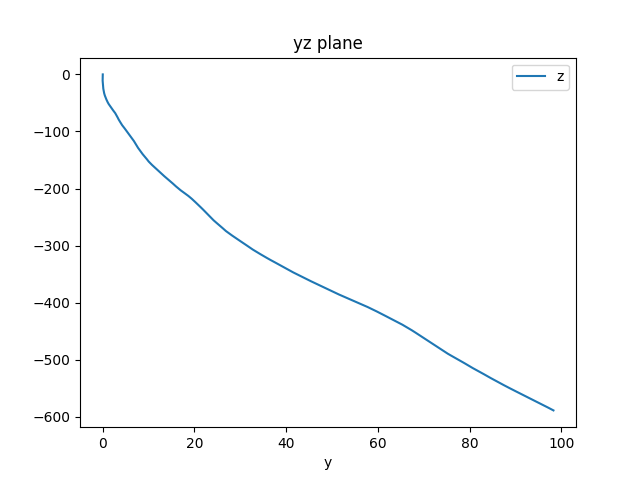

In [43]:
new_bh = simulate_borehole(sample_dist)
new_bh.plot.line(x='x', y='y', title='horizontal position')
new_bh.plot.line(x='x', y='z', title='xz plane')
new_bh.plot.line(x='y', y='z', title='yz plane')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(new_bh['x'], new_bh['y'], new_bh['z'], label='simulated borehole plot')
plt.show()

new_bh

In [53]:
def plot_multiples(borehole_list, names):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    for bh, name, in zip(borehole_list, names):
        ax.plot(bh['x'], bh['y'], bh['z'], label=bh['bh_name'])

    plt.show()

def plot_multiples2(all_boreholes):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.axis('equal')
    names = np.unique(all_boreholes['bh_name'])
    for name in names:
        single = all_boreholes[all_boreholes['bh_name'] == name]
        ax.plot(single['x'], single['y'], single['z'], label=list(single['bh_name']))
    plt.show()

def plotly_3d(df):
    fig = px.line_3d(df, x='x', y='y', z='z', color='type', line_group='bh_name')
    fig.update_layout(
        width=1000,
        height=600,
        scene_aspectmode='manual', scene_aspectratio=dict(x=1,y=1,z=1)
    )
    outline = go.Scatter3d(x=bldg_outline['x'], y=bldg_outline['y'], z=bldg_outline['z'], mode='lines', line=dict(color='grey'), name='Building Outline')
    fig.add_trace(outline)
    fig.show()

#plotly_3d(total_stats)

    
#one_sim = simulate_grid()
#plot_multiples([one_sim], ['sim'])
#plot_multiples2(one_sim)

In [55]:
def simulate_grid(nx=3, ny=3, spacing=15):
    borehole_list = []
    origins = []
    names = []
    
    for i in range(nx):
        for j in range(ny):
            name = "ABCDEFGHIJKLMNOPQRSUTVWXYZ"[i] + str(j)
            origin_x = i*spacing
            origin_y = j*spacing
            bh = simulate_borehole(sample_dist, origin_x = origin_x, origin_y = origin_y)
            bh['bh_name'] = name
            borehole_list.append(bh)
            origins.append([origin_x, origin_y])
            names.append(name)

    all_boreholes = pd.concat(borehole_list)
    return all_boreholes

#plot_multiples(borehole_list, names)

def check_for_clashes(all_boreholes, clash_distance=1):
    points = all_boreholes[['x', 'y', 'z']].values
    ids = all_boreholes['bh_name'].values
    clash_exists = False

    for bh in np.unique(ids):
        mask = (ids == bh)
        current = points[mask]
        others = points[~mask]

        tree = KDTree(others)
        idxs = tree.query_ball_point(current, r=clash_distance)
        if any(idxs):
            clash_exists = True

    return clash_exists

def run_n_sims(n_sims, clash_distance):
    n_clashes = 0
    print("\n=======")
    print(f"num sims: {n_sims}  clash_distance: {clash_distance}")
    
    for i in range(n_sims):
        print(i, end=' ')
        all_boreholes = simulate_grid()
        if check_for_clashes(all_boreholes, clash_distance):
            n_clashes += 1
            print("clash", end=' ')

    print("\n=======")
    print(f"n_sims: {n_sims}   n_clashes: {n_clashes}    ratio_clashes: {n_clashes / n_sims}")

#run_n_sims(50, 0.5)

def simulate_actual_locations(actual_boreholes, origins):
    simulation = actual_boreholes.copy()
    simulation['type'] = 'actual'
    existing_holes = np.unique(actual_boreholes['bh_name'])
    for name, loc in origins.items():
        if name not in existing_holes:
            bh = simulate_borehole(origin_x = loc[0], origin_y = loc[1])
            bh['bh_name'] = name
            bh['type'] = 'simulated'
            simulation = pd.concat([simulation, bh])
    return simulation

In [56]:
site_sim = simulate_actual_locations(total_stats, origins)        
        

In [54]:
plotly_3d(site_sim)

In [ ]:
points = all_boreholes[['x', 'y', 'z']].values
ids = all_boreholes['bh_name'].values

clash_distance = 1

for bh in np.unique(ids):
    mask = (ids == bh)
    current = points[mask]
    others = points[~mask]

    tree = KDTree(others)
    idxs = tree.query_ball_point(current, r=clash_distance)
    if any(idxs):
        print(bh)
        current_idxs = []
        for i, idx_list in enumerate(idxs):
            if any(idx_list):
                print(i, idx_list)
                print(points[i])


In [ ]:
n1 = 1429
n2 = 828
print(ids[n1], points[n1])
print(ids[n2], points[n2])

# Testing Area

In [ ]:
noise = pd.DataFrame({"x": [0], "y":[0]})

for i in range(100):
    nx = opensimplex.noise2(i)

